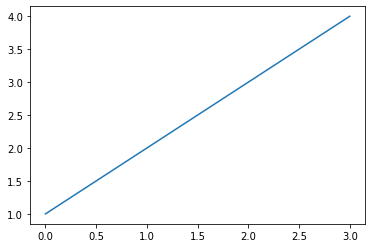

In [24]:
import sys
sys.path.append('c:/users/user-pc/appdata/local/programs/python/python310/lib/site-packages')
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])

In [25]:
import random
import gym
import sys
import numpy as np
from collections import deque,namedtuple
import os

import torch
import torch.nn as nn
from torch.optim import Adam

In [7]:
env = gym.make('LunarLander-v2')

DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`

In [ ]:
s = env.reset()
for k in range(200):
    a = random.sample([0,1,2],1)[0]
    s_prime,r,_,_ = env.step(a)
    env.render()
    

In [ ]:
state_sz = env.observation_space.shape[0]
action_sz = env.action_space.n
print('State space: ',state_sz)
print('Action space: ',action_sz)

In [ ]:
s = env.reset()
print(s)
s_prime,r,done,_ = env.step(0)
print(s_prime,r,done)

In [8]:
n_episodes=250
batch_size=256
gamma = 0.995
lr = 0.0001
eps = 1.0
decay = 0.99

In [9]:
class DQN(nn.Module):
    def __init__(self,hidden_sz):
        super().__init__()
        self.hidden_sz = hidden_sz
        
        self.fc1 = nn.Linear(state_sz,self.hidden_sz)
        self.fc2 = nn.Linear(self.hidden_sz,self.hidden_sz)
        self.fc3 = nn.Linear(self.hidden_sz,action_sz)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [10]:
replay_buffer = deque(maxlen=10000)

In [11]:
transition = namedtuple('transition',['s_prime','reward','s','action','done'])

In [12]:
def store(transition):
    replay_buffer.append(transition)

In [13]:
dq_network = DQN(256).cuda()
target_network = DQN(256).cuda()

NameError: name 'state_sz' is not defined

In [14]:
optimizer = Adam(dq_network.parameters(),lr=lr)
loss_fn = nn.MSELoss()

NameError: name 'dq_network' is not defined

In [15]:
def update():
    
    if len(replay_buffer)<batch_size:
        return
    
    batch = random.sample(replay_buffer,batch_size)
    
    s = torch.FloatTensor(np.array([t.s for t in batch])).cuda()
    r = torch.FloatTensor(np.array([t.reward for t in batch])).cuda()
    s_prime = torch.FloatTensor(np.array([t.s_prime for t in batch])).cuda()
    a = torch.LongTensor(np.array([t.action for t in batch])).unsqueeze(1).cuda()
    done = torch.FloatTensor(np.array([t.done for t in batch])).cuda()
    
    dqn_max = dq_network(s_prime).argmax(dim=1).unsqueeze(1)
    
    target = (r + gamma*target_network(s_prime).gather(1,dqn_max).squeeze(1)*(1-done))
    
    prediction = dq_network(s).gather(1,a)
    
#     print(target.size())   
#     print(prediction.size())
    
    optimizer.zero_grad()
    
    loss = loss_fn(target,prediction.squeeze(1))
    
    loss.backward()
    
    optimizer.step() 
    
    

In [16]:
class Agent():
    def __init__(self,target_update_frequency=100,eps=1):
        
        self.eps = eps
        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 0
        self.rewards = []
        
    def select_action(self,state,eps):
        
        t = np.random.random()
        if t < eps:
            a = np.random.choice(range(action_sz))
        else:
            q = dq_network(torch.FloatTensor(state).cuda())
            a = q.argmax().item()   
        return a
            
        
        
    def run_episode(self,render):

        s = env.reset()
        done = False
        total_reward = 0.0
        self.eps = self.eps * decay
        transition_count = 0
        
        while not done:
            if render:
                env.render()
                
            eps = 0.0
            
            self.target_update_counter += 1
            
            if self.eps > 0.01:
                eps = self.eps
            else:
                eps = 0.01
            
            action = self.select_action(s,eps)
            
            s_prime,reward,done,_ = env.step(action)
            
            store(transition(s_prime,reward,s,action,done))
            
            total_reward += reward
            
            s = s_prime
            
            done = done
            
            update()
            
            transition_count+=1
            
        print('Transition Count: ',transition_count)    
        print('Episode Reward: ',total_reward)    
        self.rewards.append(total_reward)
            
    def train(self):
        
        for k in range(n_episodes):
            
            render = False
            
            if k % 100 <= 10:
                render = True
            
            print('Episode: ',k)
            self.run_episode(render)
            
           

            
            if self.target_update_counter >= self.target_update_frequency:

                self.target_update_counter = 0
                target_network.load_state_dict(dq_network.state_dict())
            
            
        
            
            
            

        
                
    

In [17]:
agent = Agent()

In [18]:
%%time
agent.train()

Episode:  0


NameError: name 'env' is not defined

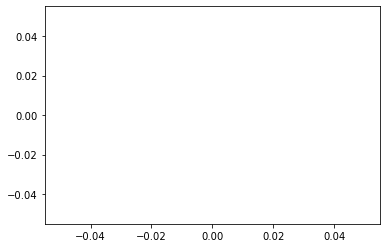

In [19]:
plt.plot(agent.rewards);

C:\Users\User-PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User-PC\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


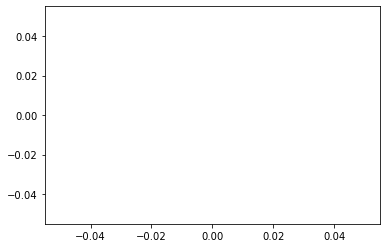

In [20]:
plt.plot([np.mean(agent.rewards[i-50:i]) for i in range(50,250)]);